# Exploratory Data Analysis
In this notebook, we use the functions we've written in various notebooks to explore how our models' analysis on news sentiment actually compares with changes in stock prices.

In [8]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import compare_sentiment as comp_sent
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dropout
from keras.callbacks import EarlyStopping

# Concat All Data

In [10]:
#Get Data
google = comp_sent.collapse_articles(data_source = "./data-mine/data/google-data.pkl", stockName = "GOOG", 
                      time_before = '2018-09-27', time_after = '2019-05-17')
apple = comp_sent.collapse_articles(data_source = "./data-mine/data/apple-data.pkl", stockName = "AAPL", 
                      time_before = '2018-09-27', time_after = '2019-05-17')
tesla = comp_sent.collapse_articles(data_source = "./data-mine/data/tesla-data.pkl", stockName = "TSLA", 
                      time_before = '2018-09-27', time_after = '2019-05-17')
micro = comp_sent.collapse_articles(data_source = "./data-mine/data/Microsoft-data.pkl", stockName = "MSFT", 
                      time_before = '2018-09-27', time_after = '2019-05-17')
amazon = comp_sent.collapse_articles(data_source = "./data-mine/data/amazon-data.pkl", stockName = "AMZN", 
                      time_before = '2018-09-27', time_after = '2019-05-17')

In [27]:
# ibm = comp_sent.collapse_articles(data_source = "./data-mine/data/IBM-pages=200-data.pkl", stockName = "IBM", 
#                       time_before = '2018-09-27', time_after = '2019-05-17')
# walmart = comp_sent.collapse_articles(data_source = "./data-mine/data/Walmart-pages=200-data.pkl", stockName = "WMT", 
#                       time_before = '2018-09-27', time_after = '2019-05-17')
# shell = comp_sent.collapse_articles(data_source = "./data-mine/data/Shell-pages=200-data.pkl", stockName = "RDS.A", 
#                       time_before = '2018-09-27', time_after = '2019-05-17')

In [28]:
all_company = pd.concat([google, apple, tesla, micro, amazon])

In [29]:
all_company['liststring'] = all_company['liststring'].apply(lambda x : x.replace("," , " "))

In [30]:
all_company['increase'] = (all_company['delta'] >= 0).astype("int")

# Word Embedding Model

In [32]:
#Tokenize the words
def tokenize(X_train, X_test, all_company):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_company['liststring'])

    # max_length = max([len(s.split()) for s in all_company['liststring']])
    max_length = 3000
    vocab_size = len(tokenizer.word_index) + 1

    X_train_tokens =  tokenizer.texts_to_sequences(X_train)
    X_test_tokens = tokenizer.texts_to_sequences(X_test)

    X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
    X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')
    
    return (X_train_pad, X_test_pad, max_length, vocab_size)

In [33]:
#Architecture 1
def embed_model(vocab_size, max_length, binary = True):
    EMBEDDING_DIM = 100
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
    model.add(GRU(units=128,  dropout=0.2, recurrent_dropout=0.2))
    
    # try using different optimizers and different optimizer configs
    if (binary):
        print('binary')
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'])
    else:
        print('non-binary')
        model.add(Dense(1, activation='relu'))
        model.compile(loss='mean_squared_error', optimizer='adam',  metrics=['mse', 'mae'])
    return model

In [36]:
#Architecture 2
def embed_model2(vocab_size, max_length, binary = True):
    EMBEDDING_DIM = 100
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length, trainable = False))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
    if (binary):
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'])
        print('binary')
    else:
        model.add(Dense(1, activation='relu'))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
        print('non-binary')
        
        
    return model

In [46]:
def plot_history(history, path):
    """
    This function plots the accuracies and losses over epochs given a neural network model.
    Params:
        history - an object returned from model.fit (from a Keras classifier)
        path - the path to save the photos
    Return:
        1 png files that show the accurarcies
    """
    # Plot accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(path)
    plt.close()

    return

## Binary Classification

In [37]:
#Train test split
#USE all_company['increase'] for Y if BINARY. 
#USE all_company['delta'] for Y if REGRESSION.
X_train, X_test, y_train, y_test = train_test_split(all_company['liststring'], all_company['increase'], test_size=0.20, random_state=42)
X_train_pad, X_test_pad, max_length, vocab_size = tokenize(X_train, X_test, all_company)

In [40]:
from keras.wrappers.scikit_learn import KerasClassifier
estimator = KerasClassifier(build_fn = embed_model2, vocab_size = vocab_size, max_length = max_length, binary = True,
                            epochs=25, batch_size=128, verbose=2)
history = estimator.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test))

binary
Train on 539 samples, validate on 135 samples
Epoch 1/25
 - 11s - loss: 0.7849 - acc: 0.4917 - val_loss: 0.6390 - val_acc: 0.6667
Epoch 2/25
 - 8s - loss: 0.6737 - acc: 0.5714 - val_loss: 0.7837 - val_acc: 0.3333
Epoch 3/25
 - 8s - loss: 0.6385 - acc: 0.5807 - val_loss: 0.6493 - val_acc: 0.6741
Epoch 4/25
 - 8s - loss: 0.5805 - acc: 0.6438 - val_loss: 0.6716 - val_acc: 0.6889
Epoch 5/25
 - 8s - loss: 0.5278 - acc: 0.9907 - val_loss: 0.6601 - val_acc: 0.7111
Epoch 6/25
 - 8s - loss: 0.4738 - acc: 0.9740 - val_loss: 0.6409 - val_acc: 0.6889
Epoch 7/25
 - 8s - loss: 0.4130 - acc: 0.9740 - val_loss: 0.7461 - val_acc: 0.4074
Epoch 8/25
 - 8s - loss: 0.3641 - acc: 0.9647 - val_loss: 0.6139 - val_acc: 0.6815
Epoch 9/25
 - 9s - loss: 0.3176 - acc: 0.9703 - val_loss: 0.6227 - val_acc: 0.6815
Epoch 10/25
 - 9s - loss: 0.2528 - acc: 0.9907 - val_loss: 0.6926 - val_acc: 0.4519
Epoch 11/25
 - 7s - loss: 0.2163 - acc: 0.9926 - val_loss: 0.7533 - val_acc: 0.4074
Epoch 12/25
 - 7s - loss: 0.179

In [49]:
plot_history(history, "./img/acc_plot/model2_binary_1")

In [52]:
X_train, X_test, y_train, y_test = train_test_split(all_company['liststring'], all_company['increase'], test_size=0.20, random_state=42)
X_train_pad, X_test_pad, max_length, vocab_size = tokenize(X_train, X_test, all_company)
estimator = KerasClassifier(build_fn = embed_model, vocab_size = vocab_size, max_length = max_length, binary = True,
                            epochs=25, batch_size=128, verbose=2)
history = estimator.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test))

binary
Train on 539 samples, validate on 135 samples
Epoch 1/25
 - 30s - loss: 0.6932 - acc: 0.5102 - val_loss: 0.6855 - val_acc: 0.6667
Epoch 2/25
 - 29s - loss: 0.6870 - acc: 0.5547 - val_loss: 0.6855 - val_acc: 0.6889
Epoch 3/25
 - 29s - loss: 0.6804 - acc: 0.6197 - val_loss: 0.6784 - val_acc: 0.6963
Epoch 4/25
 - 30s - loss: 0.6666 - acc: 0.7069 - val_loss: 0.6729 - val_acc: 0.6444
Epoch 5/25
 - 29s - loss: 0.6409 - acc: 0.7718 - val_loss: 0.6576 - val_acc: 0.6593
Epoch 6/25
 - 30s - loss: 0.5931 - acc: 0.7755 - val_loss: 0.6416 - val_acc: 0.6667
Epoch 7/25
 - 35s - loss: 0.5213 - acc: 0.7848 - val_loss: 0.7143 - val_acc: 0.5185
Epoch 8/25
 - 35s - loss: 0.5037 - acc: 0.7996 - val_loss: 0.6684 - val_acc: 0.5852
Epoch 9/25
 - 33s - loss: 0.4218 - acc: 0.7996 - val_loss: 0.6485 - val_acc: 0.6370
Epoch 10/25
 - 33s - loss: 0.3757 - acc: 0.8237 - val_loss: 0.6638 - val_acc: 0.6370
Epoch 11/25
 - 33s - loss: 0.3308 - acc: 0.8256 - val_loss: 0.7227 - val_acc: 0.5556
Epoch 12/25
 - 31s - 

In [53]:
plot_history(history, "./img/acc_plot/model1_binary_1")

## Regression

In [54]:
# #Train test split
# #USE all_company['increase'] for Y if BINARY. 
# #USE all_company['delta'] for Y if REGRESSION.
# X_train, X_test, y_train, y_test = train_test_split(all_company['liststring'], all_company['delta'], test_size=0.20, random_state=42)
# X_train_pad, X_test_pad, max_length, vocab_size = tokenize(X_train, X_test, all_company)
# estimator = KerasClassifier(build_fn = embed_model, vocab_size = vocab_size, max_length = 3000, binary = False,
#                             epochs=50, batch_size=32, verbose=2)
# history2 = estimator.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test))

In [47]:
import sklearn.preprocessing as preprocessing 
scale = preprocessing.MinMaxScaler()
Y_final = pd.DataFrame(scale.fit_transform(Y_final.values))
Y_final.rename(columns = {0: "Y_test", 1: "Y_pred"}, inplace = True)

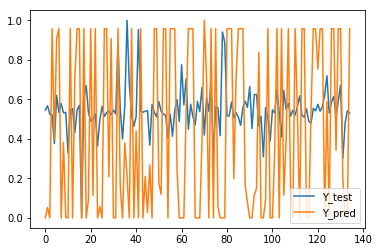

In [48]:
Y_final.plot(kind = 'line')